# Practice Session 09: Viral Propagation

<font size="+2" color="blue">Additional results: targeted immunization</font>

# 1. The SFHH Conference Dataset

In [106]:
import io
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

In [107]:
INPUT_FILENAME = "sfhh-conference-2009.csv"

In [108]:
# LEAVE AS-IS

# Create a new undirected graph
g = nx.Graph()

with io.open(INPUT_FILENAME) as input_file:
    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')
    
    # Iterate through records, each record is a dictionary
    for record in reader:
        
        # Add one edge per record
        g.add_edge(record['Source'], record['Target'])

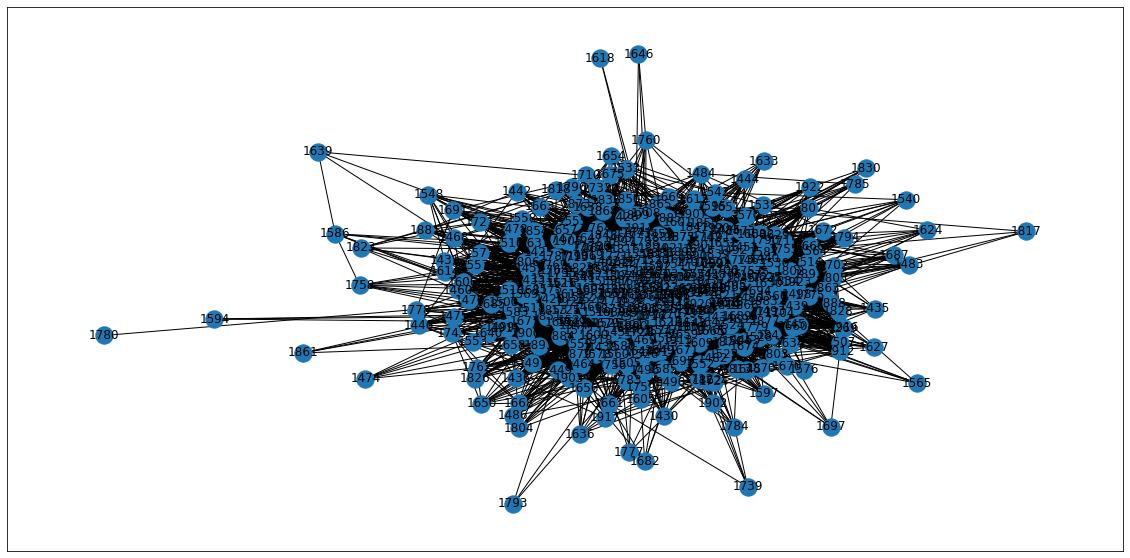

In [109]:
# LEAVE AS-IS

# Create an empty figure; feel free to change size to accommodate to your screen
plt.figure(figsize=(20,10))

# Draw the graph
nx.draw_networkx(g)

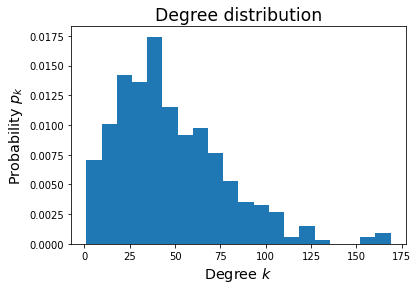

Degree: 47.5 +/- 30.1, range [1, 169]


In [110]:
# LEAVE AS-IS

def plot_degree_dist(graph):
    
    # Obtain the sequence of degree of nodes
    # Function graph.degree() return tuples (node,degree)
    degrees = [degree_tuple[1] for degree_tuple in graph.degree()]
    
    # Draw the histogram of the degree
    plt.hist(degrees, density=True, bins=20)
    plt.title("Degree distribution", fontdict={'fontsize': 'xx-large'})
    plt.xlabel("Degree $k$", fontdict={'fontsize': 'x-large'})
    plt.ylabel("Probability $p_k$", fontdict={'fontsize': 'x-large'})
    plt.show()
    
    # Print some degree statistics
    print("Degree: {:.1f} +/- {:.1f}, range [{:d}, {:d}]".format(
        np.mean(degrees), np.std(degrees), np.min(degrees), np.max(degrees)))
    
plot_degree_dist(g)



Esta no es una red libre de escala ya que como vemos, la forma de la distribución de grado es del estilo de una distribución de Poisson, característica de los grafos aleatorios. Además como se explica en la práctica, se trata de un grafo que explica interacciones aleatorias entre asistentes a una conferencia, por lo que es lógico que surga una distribución de grado de este estilo.

# 2. Independent cascade model

In [111]:
def infect_recursive(graph, starting_node, beta, infected):
  infected[starting_node] = True #Se infecta el nodo de entrada
  for node in graph.neighbors(starting_node):
      if infected[node] == False:#Si el nodo no está infectado
        if beta>random.uniform(0,1):#Con probabilidad beta, se llama a infect_recursive
          infect_recursive(graph, node, beta, infected)


def simulate_independent_cascade(graph, starting_node, beta):
    infected = dict([(node, False) for node in graph.nodes()]) #Inicializa el diccionario
    infect_recursive(graph, starting_node, beta, infected) #Llama infect recursive con el nodo de entrada
    
    return infected

In [112]:
def simulate_multiple_independent_cascades(graph, beta, repetitions):
  infections = 0
  #Se hacen tantas repeticiones como se indique y se calcula la media de la fracción de infectados
  for i in range(repetitions):
    #Escoje un nodo inicial al azar
    starting_node = random.choice(list(g.nodes()))
    #Crea diccionario con las infecciones
    infected = simulate_independent_cascade(graph, starting_node, beta)
    #Suma las infecciones totales
    infections += sum(infected.values())
  #retorna la fraccion media de infectados
  return (infections/repetitions)/graph.number_of_nodes()
  

In [113]:
# LEAVE AS-IS

REPETITIONS=100
for beta in [0.01, 0.1, 0.2, 0.9, 1.0]:
    print("Beta={:.2f}; Fraction of infected={:.6f} (average of {:d} runs)".format(
        beta,
        simulate_multiple_independent_cascades(g, beta, REPETITIONS),
        REPETITIONS
    ))

Beta=0.01; Fraction of infected=0.007097 (average of 100 runs)
Beta=0.10; Fraction of infected=0.860521 (average of 100 runs)
Beta=0.20; Fraction of infected=0.965633 (average of 100 runs)
Beta=0.90; Fraction of infected=0.999677 (average of 100 runs)
Beta=1.00; Fraction of infected=1.000000 (average of 100 runs)


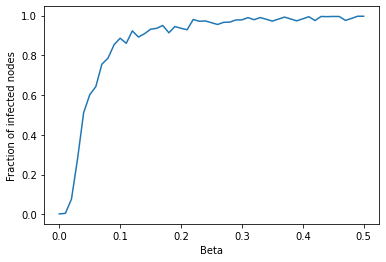

In [114]:

#Diccionario que relaciona la beta con la fraccion de infectados
beta2fraction = {}

for beta in np.arange(0.0, 0.51, 0.01):
  beta2fraction[beta] = simulate_multiple_independent_cascades(g, beta, REPETITIONS)

#Valores 'x' son cada una de las beta
x_vals_random = sorted(beta2fraction.keys())

#Los valores de 'y' de beta2fraction son los valores que retorna cada una de las claves
y_vals_random = [beta2fraction[x] for x in x_vals_random]


#Descripción eje x
plt.xlabel("Beta")

#Descripción eje y
plt.ylabel("Fraction of infected nodes")

#Grafica los valores de beta2fraction
plt.plot(x_vals_random, y_vals_random)


plt.show()



 Se pude observar que la fracción de nodos infectados aumenta a medida que aumenta la probabilidad de infección, como es obvio. Observamos sin embargo, a partir de una probabilidad de infección de alrededor del 10%, prácticamente todos los nodos estarán contagiados y a partir de aquí, a medida que se aumente beta, la fracción de nodos contagiados aumentará de manera más lenta.

# 3. Reduce maximum degree

In [115]:

def graph_max_degree(graph, max_degree):
  #Crea grafo vacío
  g_out = nx.Graph()
  for node in graph.nodes():
    #Añade todos los nodos del grafo original
    g_out.add_node(node)

  edges = np.random.permutation(graph.edges())#Se 'baraja' la posición de cada edge en una lista de manera aleatoria para iterarla
  
  for u, v in edges:
    #Siempre que ambos nodos no superen el grado máximo, se añade el enlace a la copia del grafo
    if (g_out.degree(u))< max_degree and (g_out.degree(v)) < max_degree:
      g_out.add_edge(u, v)
  #retorna la copia del grafo
  return g_out




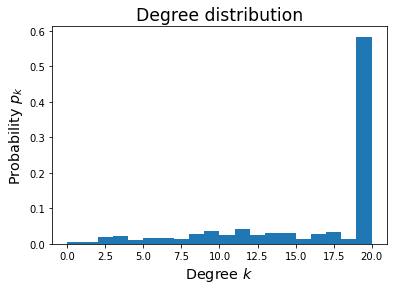

Degree: 15.9 +/- 5.7, range [0, 20]


In [116]:
# LEAVE AS-IS

# Reduce the max degree of the graph
gmax = graph_max_degree(g, 20)

# If you notice nodes with degree larger than specified,
# it means your graph_max_degree function is deffective.
plot_degree_dist(gmax)

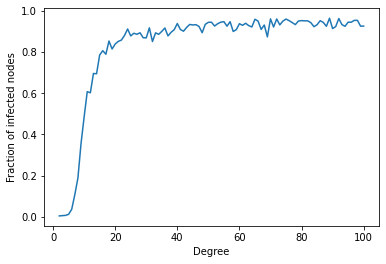

In [117]:

BETA = 0.2
REPETITIONS = 100

#Diccionario que relaciona el grado con la fracción de infectados
degree2fraction = {}
for degree in np.arange(2, 101, 1):
  #Crea el grafo con dicho grado máximo
  g_out = graph_max_degree(g, degree)
  #Simula el proceso de infección en el grafo con el grado máximo establecido
  degree2fraction[degree] = simulate_multiple_independent_cascades(g_out, BETA, REPETITIONS)

#Valores 'x' son cada una de los grados máximos
x_vals_random = sorted(degree2fraction.keys())

#Los valores de 'y' de degree2fraction son los valores que retorna cada una de las claves
y_vals_random = [degree2fraction[x] for x in x_vals_random]


#Descripción eje x
plt.xlabel("Degree")

#Descripción eje y
plt.ylabel("Fraction of infected nodes")

#Grafica los valores de degree2fraction
plt.plot(x_vals_random, y_vals_random)


plt.show()



Si observamos el grafo, se podría decir que para que la fracción de nodos sea 0.5, deberíamos de establecer el grado entre 10 y 11 aproximadamente. 
Podemos ver como el gráfico es muy parecido al obtenido anteriormente. En este caso, obtenemos que prácticamente todo el grafo se infecta a partir de un grado máximo de 20, mientras que antes obteníamos esta cantidad de contagios a partir de BETA = 0.1. 

Es fácil de entender por qué incrementa la cantidad de nodos infectados a medida que aumentamos el grado máximo de los nodos. A medida que puede haber un grado mayor, es más probable un nodo infectado infecte a una mayor cantidad de nodos ya que es probable que tenga una mayor cantidad de vecinos(susceptibles a infección).


# 4. Random vs friendship paradox immunization

In [118]:
def give_immunity_random(graph, fraction):
  #Inicializa diccionario
  immune = dict([(node, False) for node in graph.nodes()])
  N = graph.number_of_nodes()*fraction

  #Mientras la fracción de nodos immunizados no se haya alcanzado, se immuniza a nodos de manera aleatoria(que no estén ya immunizados)
  while sum(immune.values()) < N:
    node = random.choice(list(g.nodes()))
    if immune[node]== False:
      immune[node] = True
  

        
  return immune


In [119]:
# LEAVE AS-IS

def test_immunize(graph, method, values):
    for fraction in values:
        immunity = method(g, fraction)
        number_immunized = sum(immunity.values())
        number_not_immunized = len(immunity) - number_immunized
        fraction_immunized = number_immunized / (number_immunized + number_not_immunized)
        print("Immunized {:.1f}% of nodes; got a dictionary with {:d} 'True' and {:d} 'False' values ({:.1f}% 'True')".format(
            fraction*100,
            number_immunized,
            number_not_immunized,
            fraction_immunized*100
        ))

test_immunize(g, give_immunity_random, [0.1, 0.3, 0.7])

Immunized 10.0% of nodes; got a dictionary with 41 'True' and 362 'False' values (10.2% 'True')
Immunized 30.0% of nodes; got a dictionary with 121 'True' and 282 'False' values (30.0% 'True')
Immunized 70.0% of nodes; got a dictionary with 283 'True' and 120 'False' values (70.2% 'True')


In [120]:
def give_immunity_random_friend(graph, fraction):
  immune = dict([(node, False) for node in graph.nodes()])
  
  N = graph.number_of_nodes()*fraction

  #Mientras la fracción de nodos immunizados no se haya alcanzado, se immuniza a vecinos(que no estén ya immunizados) de nodos escogidos aleatoriamente
  while sum(immune.values()) < N:
    node = random.choice(list(graph.nodes()))
    neighbor = random.choice(list(g.neighbors(node)))
    if immune[neighbor] == False:
      immune[neighbor] = True

  

  return immune
 


  

In [121]:
# LEAVE AS-IS

test_immunize(g, give_immunity_random_friend, [0.1, 0.3, 0.7])

Immunized 10.0% of nodes; got a dictionary with 41 'True' and 362 'False' values (10.2% 'True')
Immunized 30.0% of nodes; got a dictionary with 121 'True' and 282 'False' values (30.0% 'True')
Immunized 70.0% of nodes; got a dictionary with 283 'True' and 120 'False' values (70.2% 'True')


In [122]:
def infect_recursive_variation(graph, starting_node, beta, infected, immune):
  #Funciona igual que la anterior pero se añade la condición de que el nodo no sea immune
  infected[starting_node] = True
  for node in graph.neighbors(starting_node):
      if infected[node] == False and immune[node] == False:
        if random.uniform(0,1)<beta:
          infect_recursive_variation(graph, node, beta, infected, immune)


def simulate_independent_cascade_variation(graph, starting_node, beta, immune):
    infected = dict([(node, False) for node in graph.nodes()])
    #Funciona como antes pero revisa que el nodo que entra a infect_recursive no sea immune
    if immune[starting_node] == False:
      infect_recursive_variation(graph, starting_node, beta, infected, immune)
    
    return infected


In [123]:
#Reutilzo la función haciendo unas modificaciones para simular para cada fracción de nodos immunes 
def simulate_multiple_independent_cascades_variation(graph, beta, repetitions, method, fraction):
  #Inicializo contador de infections
  infections = 0
  
  N = graph.number_of_nodes()
  #Crea diccionario immunes
  immunity = method(graph, fraction)
  for i in range(repetitions): 
    #Nodo inicial aleatorio
    starting_node = random.choice(list(graph.nodes()))

    #Diccionario infecciones con la función modificada anteriormente
    infected = simulate_independent_cascade_variation(graph, starting_node, beta, immunity)
    #Añade al contador la fracción de nodos infectados en cada caso
    infections += sum(infected.values())/N


  #Se obtiene la media de fracción de infecciones
  infected_fraction = infections/repetitions
  
  return infected_fraction
  

In [124]:
#Diccionario de fracción immune a fracción infectada immunizando a los nodos vecinos del nodo
fraction_infected_friends = {}

#Diccionario de fracción immune a fracción infectada immunizando a los nodos aleatoriamente
fraction_infected_random = {}

#Se obtienen los diccionarios con fracciones de immunizados de 0 a 1.
for fraction in np.arange(0.0, 1.05, 0.05):

  fraction_infected_friends[fraction] = simulate_multiple_independent_cascades_variation(g, 0.03, 800, give_immunity_random_friend, fraction)
  fraction_infected_random[fraction] = simulate_multiple_independent_cascades_variation(g, 0.03, 800, give_immunity_random, fraction)
  



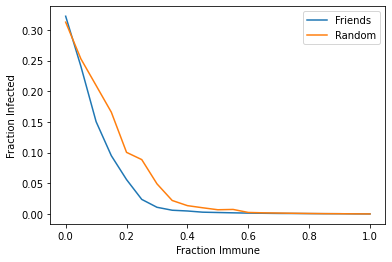

In [125]:





#Valores en el eje x para el diccionario fraction_infected_friends (son las distintas fracciones de immunes)
x_vals_friends = sorted(fraction_infected_friends.keys())
#Los valores de 'y' de fraction_infected_friends son los valores que retorna cada una de las claves(fracción de infectados)
y_vals_friends = [fraction_infected_friends[x] for x in x_vals_friends]

#Valores en el eje x para el diccionario fraction_infected_random (son las distintas fracciones de immunes)
x_vals_random = sorted(fraction_infected_random.keys())

#Los valores de 'y' de fraction_infected_random son los valores que retorna cada una de las claves(fracción de infectados)
y_vals_random = [fraction_infected_random[x] for x in x_vals_friends]


#Descripción eje x
plt.xlabel("Fraction Immune")

#Descripción eje y
plt.ylabel("Fraction Infected")

#Grafica los valores de fraction_infected_friends y fraction_infected_random
plt.plot(x_vals_friends, y_vals_friends, label = "Friends")
plt.plot(x_vals_random, y_vals_random, label = "Random")

#Añade laleyenda
plt.legend()


plt.show()


Es cierto que el comportamiento en términos generales de ambos métodos, es el mismo. Sin embargo hay ciertas diferencias sustanciales observables a simple vista. La principal distinción entre un método y el otro es que parece ser que es mejor immunizar mediante un "amigo" aleatorio de un nodo "aleatorio" que del propio nodo. Esto es porque como se visualiza en la gráfica, con una menor fracción de immunización, se puede conseguir la misma fracción de infectados que mediante el método "random". Esto se mantiene hasta aproximadamente una fracción de immunizados cercana al 50%, para la que ambos métodos parecen funcionar igual.

El fenómeno que explica porqué sucede esto es la llamada "friendship paradox". Ésta, explica que un vecino al azar escogido de un nodo al azar tendrá un grado mayor al grado medio. Por ello, es mejor immunizar a los nodos vecinos de un nodo aleatorio, ya que así se immuniza, generalmente, a nodos con grado mayor que el grado medio y evita una expansión más rápida de la infección.

# 5. Limitations


Estas simulaciones tienen varias limitaciones. Una de las más simples de ver es que no todos los nodos deberían de tener la misma probabilidad de contraer la infección no no. Otro aspecto que limita los resultados de estas simulaciones es el hecho de que se asume que una vez infectado uno no se puede recuperar o que una vez se es immune, no un nodo no puede ser susceptible a contraer la infección. En general, en estas simulaciones se asumen una serie de hechos que pueden variar dependiendo de la infección, las características de los nodos, etc.  Por esto y muchos otros motivos, uno no se puede basar en estas simulaciones sobre como controlar las pandemias en general ya que cada una tendrá unas características u otras que podrían distanciarse de los resultados obtenidos en las simulaciones de manera radical.

In [126]:
def targeted_immunization(graph, fraction):
  #Inicializa diccionario que relaciona cada nodo con su grado
  node2degree = {}
  for node in graph.nodes():
    node2degree[node] = graph.degree(node)
  #Inicializa diccionario immunes
  immune = dict([(node, False) for node in graph.nodes()])
  N = graph.number_of_nodes()*fraction

  while N> sum(immune.values()):
    #Se busca el grado máximo del grafo
    max_degree = max(node2degree.values())
    #Se crea una lista con aquellos nodos con el grado máximo
    nodes = [node for node in node2degree if node2degree[node] == max_degree]
    
    #A medida que estos nodos se van immunizando, los elimino del diccionario(una vez immunizados, el grado máximo de los nodos no immunes será distinto) 
    if immune[nodes[0]] == False:
        immune[nodes[0]] = True
        node2degree.pop(nodes[0])
  return immune



In [127]:
#Diccionario de fracción immune a fracción infectada immunizando a los nodos vecinos del nodo
fraction_infected_friends_2 = {}

#Diccionario de fracción immune a fracción infectada immunizando a los nodos aleatoriamente
fraction_infected_random_2 = {}

#Diccionario de fracción immune a fracción infectada immunizando a los nodos con mayor grado
fraction_infected_targeted = {}
#Se obtienen los diccionarios con fracciones de immunizados de 0 a 1.
for fraction in np.arange(0.0, 1.05, 0.05):

  fraction_infected_friends_2[fraction] = simulate_multiple_independent_cascades_variation(g, 0.03, 800, give_immunity_random_friend, fraction)
  fraction_infected_random_2[fraction] = simulate_multiple_independent_cascades_variation(g, 0.03, 800, give_immunity_random, fraction)
  fraction_infected_targeted[fraction] = simulate_multiple_independent_cascades_variation(g, 0.03, 800, targeted_immunization, fraction)
  



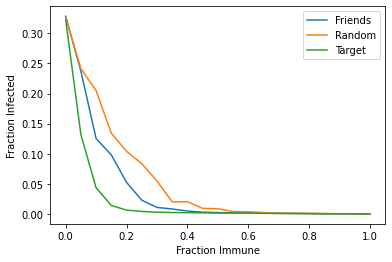

In [128]:





#Valores en el eje x para el diccionario fraction_infected_friends (son las distintas fracciones de immunes)
x_vals_friends_2 = sorted(fraction_infected_friends_2.keys())
#Los valores de 'y' de fraction_infected_friends son los valores que retorna cada una de las claves(fracción de infectados)
y_vals_friends_2 = [fraction_infected_friends_2[x] for x in x_vals_friends_2]

#Valores en el eje x para el diccionario fraction_infected_random (son las distintas fracciones de immunes)
x_vals_random_2 = sorted(fraction_infected_random_2.keys())

#Los valores de 'y' de fraction_infected_random son los valores que retorna cada una de las claves(fracción de infectados)
y_vals_random_2 = [fraction_infected_random_2[x] for x in x_vals_friends_2]

#Valores en el eje x para el diccionario fraction_infected_targeted (son las distintas fracciones de immunes)
x_vals_target = sorted(fraction_infected_targeted.keys())

#Los valores de 'y' de fraction_infected_targeted son los valores que retorna cada una de las claves(fracción de infectados)
y_vals_target = [fraction_infected_targeted[x] for x in x_vals_target]



#Descripción eje x
plt.xlabel("Fraction Immune")

#Descripción eje y
plt.ylabel("Fraction Infected")

#Grafica los valores de fraction_infected_friends y fraction_infected_random
plt.plot(x_vals_friends_2, y_vals_friends_2, label = "Friends")
plt.plot(x_vals_random_2, y_vals_random_2, label = "Random")
plt.plot(x_vals_target, y_vals_target, label = "Target")



#Añade laleyenda
plt.legend()


plt.show()

En este último caso observamos que, como era previsible, la mejor manera de immunizar una red es immunizando primero a aquellos nopdos con un mayor grado ya que de este modo, se evita que estos se contagien y puedan contagiar a potencialmente muchos otros nodos(debido a su alto grado). Este es un método mejor que immunizando mediante amigos ya que el nodo a immunizar no será solamente mayor al grado promedio(como ocurría) sino que será el de mayor grado. Finalmente, el peor de los métodos es immunizar nodos aleatoriamente ya que se immunizaran de media a los nodos con grado medio por lo que esta técnica es la que menos frena el contagio. La diferencia clave por lo tanto, está en el grado de los nodos que se están immunizando. 

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>